# AutoMPC Demo

Welcome!  This notebook demonstrates the core features of AutoMPC.

AutoMPC is designed to simplify the process of creating a controller for a robot system with unknown dynamics.
A standard approach to solving this problem is 1) use a System ID algorithm to produce a model of the system dynamics
from data, 2) design an objective which captures the task you want to solve, 3) use an optimization algorithm to solve for a control sequence with respect  to the model and objective function.  AutoMPC provides a toolbox of algorithms for  all three steps, and automates the process of hyperparameter selection for each component.

In this notebook, we will use the cart-pole swing-up task as an example.  Although we know the ground truth dynamics for the cart-pole system, we will demonstrate how to work with an unknown dynamical system by using a multi-layer perceptron (MLP) to learn the dynamics from data.  We will design our model predictive controller using a standard quadratic objective function and an iterative LQR optimizer.

## Set-Up

First, we will import the autompc library and other necessary dependancies.

In [1]:
import autompc as ampc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

Loading AutoMPC...
Finished loading AutoMPC


The benchmarks module provides some tools for quickly building example problems.  For a list of available benchmarks, see [here](https://autompc.readthedocs.io/en/latest/source/benchmarks.html#available-benchmarks).  Here we will import the cart-pole benchmark

In [2]:
from autompc.benchmarks import CartpoleSwingupV2Benchmark

benchmark = CartpoleSwingupV2Benchmark()

The `system` object defines the observation and contorl dimensions of the cartpole, while the `task` defines the task we want to solve.  Here, we will just get these from the benchmark, but for more details on systems see example [1. Basics](https://github.com/williamedwards/autompc/tree/main/examples) and for more details on tasks see example [3. Controllers and Tasks](https://github.com/williamedwards/autompc/tree/main/examples).

In [3]:
# Get system and task specification
system = benchmark.system
task   = benchmark.task

We also need a dataset of trajectories sampled from the system to use for system identification and tuning.  On a real system, we would collect these from the robot, but here we'll use another method from our benchmark to generate the dataset.  The default option is to generate trajectories using uniform random controls.

In [4]:
# Generate benchmark dataset
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

The benchmark also provides capabilities to visualize trajectories.  We can use this to visualize one of the trajectories in our training set.  Since the dataset was generated using uniform random controls, we see that this trajectory clearly does not accomplish the cart-pole swing-up task.  (Note: the animation may take a minute to generate).

<IPython.core.display.Javascript object>


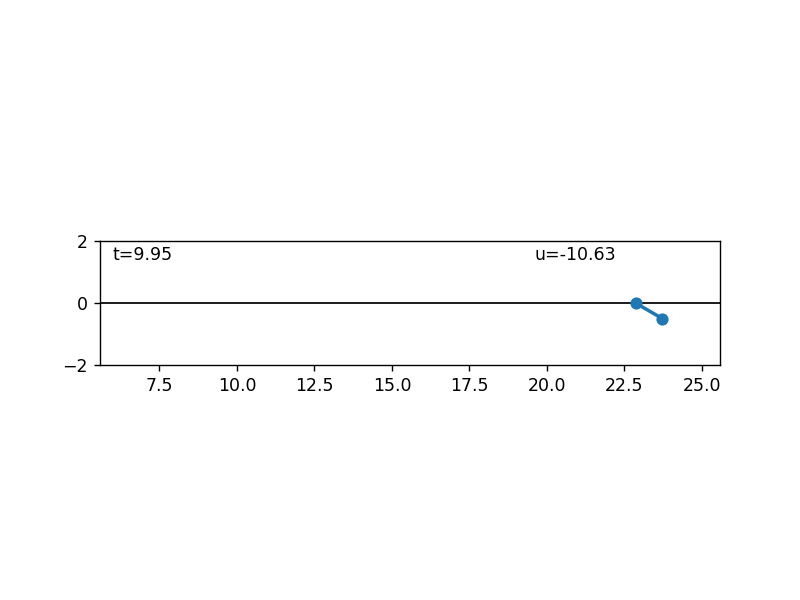

In [5]:
from IPython.display import HTML

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, trajs[1])
HTML(anim.to_html5_video())

Next, we need to create an MPC to be tuned.  Here, we will use the most general form, AutoSelectController, which allows AutoMPC to automatically select between all of its system ID, optimization, and OCP generation algorithms.

In [6]:
from autompc import AutoSelectController
controller = AutoSelectController(system)

We can view the tunable hyperparameters of the controller.  Since AutoSelectController chooses between all possible models and optimizers, the hyperparameter space is quite large!

In [7]:
controller.get_config_space()

Configuration space object:
  Hyperparameters:
    ARX:history, Type: UniformInteger, Range: [1, 10], Default: 4
    DirectTranscription:horizon, Type: UniformInteger, Range: [1, 30], Default: 10
    IterativeLQR:horizon, Type: UniformInteger, Range: [5, 25], Default: 20
    Koopman:lasso_alpha, Type: UniformFloat, Range: [1e-10, 100.0], Default: 1.0, on log-scale
    Koopman:method, Type: Categorical, Choices: {lstsq, lasso, stable}, Default: lstsq
    Koopman:poly_basis, Type: Categorical, Choices: {true, false}, Default: false
    Koopman:poly_cross_terms, Type: Categorical, Choices: {false}, Default: false
    Koopman:poly_degree, Type: UniformInteger, Range: [2, 8], Default: 3
    Koopman:trig_basis, Type: Categorical, Choices: {true, false}, Default: false
    Koopman:trig_freq, Type: UniformInteger, Range: [1, 8], Default: 1
    Koopman:trig_interaction, Type: Categorical, Choices: {false}, Default: false
    LQR:finite_horizon, Type: Categorical, Choices: {true, false}, Default

## Tuning

Once we have initialized the pipeline and its factories, we can set up a tuner to automatically search over the pipeline's configuration space.  Since we assume we don't have access to the ground truth dynamics, we train a surrogate dynamics model, which is used as a simulator to evaluate configurations.

Here we pass an `MLP` instance to the tuner to be used to train the surrogate dynamics model.  The `surrogate_split` controls what proportion of the data will be used for training the surrogate dynamics model vs trainin gthe system ID model.

This is an example of full pipeline which searches the configuration space of all pipeline components simultaneously.  (NOTE: This takes quite a while to run.  Skip this cell and run the next one instead to load a cached result).

In [8]:
from autompc.tuning import ControlTuner
from autompc.sysid import MLP

tuner = ControlTuner(surrogate=MLP(system), surrogate_split=0.5)

/usr/lib/python3/dist-packages/pyparsing.py:1745: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


We can now run the tuning porcess.  In addition to the pipeline, we pass the task and the trajectory dataset.  The task specification is used to evaluate the trajectories simulated with the surrogate dynamics model.  AutoMPC uses the `smac3` package for Bayesian optimization to search the configuration space.

Here, we pass the ground truth dynamics to the tuner so that we can measure the true performance over time.  However, we would not have this for a real robot, so it's not used for selecting the configuration.

**Note:** The tuning process can take 5 or more hours to run depending on the hardware available.  To load a cached result instead of running this yourself, skip this cell and run the next one instead.

In [9]:
tuned_controller, tune_result = tuner.run(controller, task, trajs, n_iters=100, rng=np.random.default_rng(100), 
                                   truedyn=benchmark.dynamics,
                                   restore_dir="autompc-output_2022-02-10T17:10:43")

Adding unsupported scenario options: {'save_results_instantly': True}


100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


Run the below cell to load a cached tune result

In [10]:
#import os, pickle
#current_folder = globals()['_dh'][0]
#fn = os.path.join(current_folder, "../assets/cached_tunes/cartpole_tune_result.pkl")
#with open(fn, "rb") as f:
#    tune_result = pickle.load(f)
#inc_cfg = tune_result.inc_cfg
#controller, cost, model = pipeline(inc_cfg, task, trajs)

We can then plot the performance of the best controller found so far over the iterations of the tuning process.  We plot both the performance as evaluated with the surrogate dynamics and the true dynamics performance.  Lower scores are better, so after 100 iterations, both the surrogate and true performance converge to a good solution.

<IPython.core.display.Javascript object>


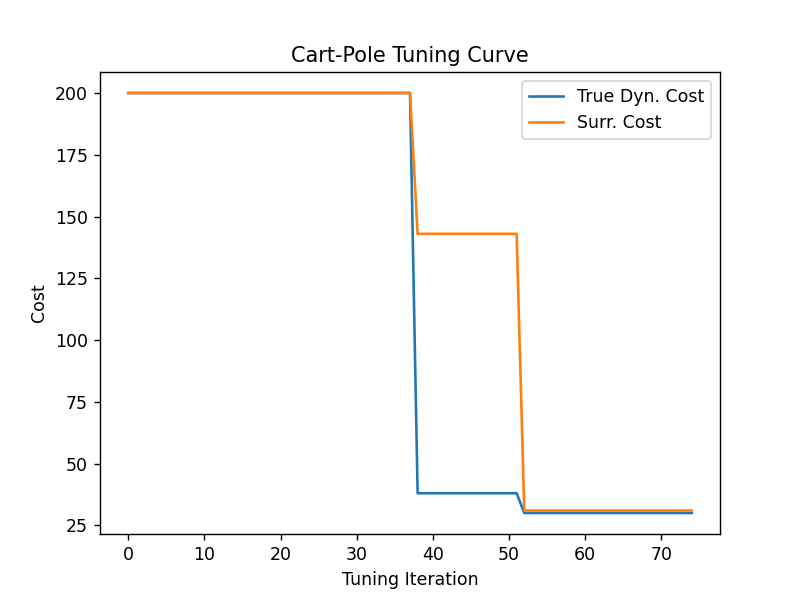

In [11]:
from autompc.graphs import TuningCurveGraph
import matplotlib.pyplot as plt

graph = TuningCurveGraph()

fig = plt.figure()      
ax = fig.gca()
graph(ax, tune_result)
ax.set_title("Cart-Pole Tuning Curve")
plt.show()

We can also view the configurations selected by the tuner.

In [ ]:
tune_result.inc_cfg

Now that our tuning process has given us a controller, we can run it to simulate a trajectory.  For more information on how to work with controllers, see example [3. Controllesr .

In [12]:
traj = ampc.simulate(tuned_controller, init_obs=benchmark.task.get_init_obs(), max_steps=200, dynamics=benchmark.dynamics)

100%|██████████| 200/200 [00:10<00:00, 19.75it/s]


<IPython.core.display.Javascript object>


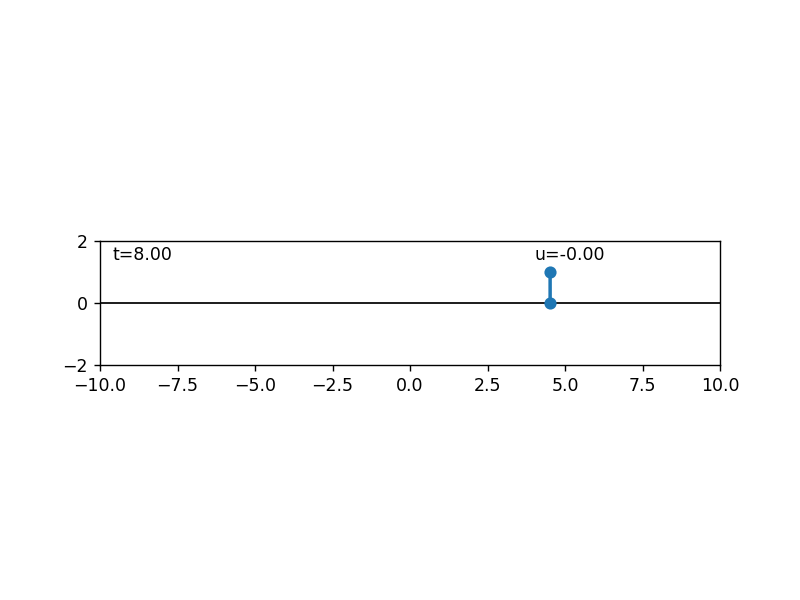

In [13]:
fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj)
HTML(anim.to_html5_video())

In [17]:
import pickle
with open("../assets/cached_tunes/cartpole_v2_result_01.pkl", "wb") as f:
    pickle.dump(tune_result, f)